In [134]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import torch
from utils import cka as CKA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import os
from tqdm import tqdm

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset

In [136]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture    = 'B_12-Wi_1024'
data_resolution = 32                      # Resolution of data as it is stored
crop_resolution = 64                      # Resolution of fine-tuned model (64 for all models we provide)
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/ffcv'
eval_batch_size = 512
checkpoint      = 'in21k_cifar10'         # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

cka_internal    = False                   # True: Compute similarities between layers of the same net. False: compare layers across models
model1_type     = 'MLP'                   # MLP, CNN, VIT
model2_type     = 'MLP'                   # MLP, CNN, VIT

In [137]:
# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


if cka_internal:
    # Define the model and specify the pre-trained weights
    model1 = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                       checkpoint= checkpoint)
else:
    model1 = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                       checkpoint= checkpoint)
    model2 = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                       checkpoint= checkpoint)

Weights already downloaded
Load_state output <All keys matched successfully>
Weights already downloaded
Load_state output <All keys matched successfully>


In [138]:
# Get the custom test loader need to take care of different image sizes. Now fixed only for mlp with 64x64
loader = get_loader(
    dataset,
    bs=eval_batch_size,
    mode="test",
    augment=False,
    dev=device,
    mixup=0.0,
    data_path=data_path,
    data_resolution=data_resolution,
    crop_resolution=crop_resolution,
)

Loading /scratch/ffcv/cifar10/val_32.beton


In [139]:
@torch.no_grad()
def compute_cka_internal(model, loader, cka, model_type):

    model.eval()
    #register hooks
    activations = {} 
    CKA.register_hooks(model, activations)
    i = 0 
    for ims, targs in tqdm(loader, desc="Evaluation"):
        
        if model_type == 'MLP': ims   = torch.reshape(ims, (ims.shape[0], -1))
        CKA.process_batch(model, ims, cka, activations)
        
    return cka.result()

In [148]:
@torch.no_grad()
def compute_cka_across(model1, model2, loader, cka, model1_type, mdoel2_type):

    model1.eval()
    model2.eval()
    #register hooks
    activations1 = {}
    activations2 = {} 
    CKA.register_hooks(model1, activations1)
    CKA.register_hooks(model2, activations2)
    
    for ims, targs in tqdm(loader, desc="Evaluation"):
        
        if model1_type == 'MLP': 
            ims   = torch.reshape(ims, (ims.shape[0], -1))
        if model2_type == 'MLP':
            pass
            print("need work")

        acts1 = CKA.get_activations(ims, model1, activations1)
        acts2 = CKA.get_activations(ims, model2, activations2)

        cka.update_state_across_models(acts1, acts2)
        
    return cka.result()

The parameter cka_internal has value False
yoooop


Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

need work


Evaluation:   0%|          | 0/20 [00:04<?, ?it/s]


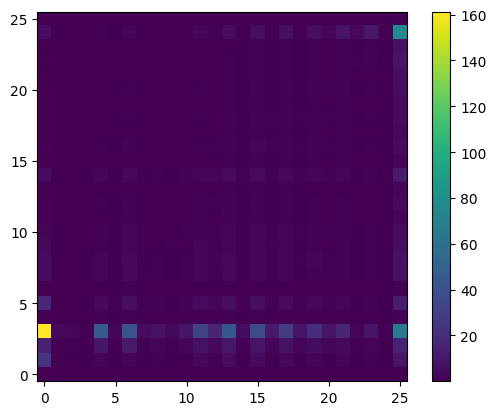

In [149]:
import matplotlib.pyplot as plt

print("The parameter cka_internal has value", cka_internal)
if cka_internal:
    _, n_layers = CKA.find_layers(model1)
    cka         = CKA.MinibatchCKA(n_layers, None, cka_internal)
    heatmap     = compute_cka_internal(model1, loader, cka, model1_type) 
else:
    _, n_layers1 = CKA.find_layers(model1)
    _, n_layers2 = CKA.find_layers(model2)
    cka          = CKA.MinibatchCKA(n_layers1, n_layers2, across_models=True)
    heatmap      = compute_cka_across(model1, model2, loader, cka, model1_type, model2_type)

heatmap = heatmap.numpy()
plt.imshow(heatmap, cmap = 'viridis', origin = 'lower')
plt.colorbar()
plt.show()